In [1]:
import time
import math
import numpy as np
import collections
from numpy import linalg as la
import json
import matplotlib.pyplot as plt 
import seaborn as sns
import networkx as nx

import pandas as pd
import random as rnd
import scipy.sparse as sparse
import random
import implicit 
import datetime

data_path = '../data/one100K_v2.json'

#### Simply we load the data from our scrapped tweets file: one100K_v2.json to a list tweets

In [2]:
## LOAD OUR DATA FROM THE SCRAPPED TWEETS
docs_path = data_path
with open(docs_path) as fp:
    lines = fp.readlines()
tweets = [l.strip().replace(' +', ' ') for l in lines]

In [3]:
print("Total numer of tweets in the corpus: {}" .format(len(tweets)))

Total numer of tweets in the corpus: 100001


#### Create a dictionary for each tweet
For each tweet, creates a dictionary containing the most relevant information of it (Username, OriginalText, Clean Tokens, number of Likes, number of retweets, list of URLs...)
    
    Argument:  tweet -- a JSON tweet content    
    Returns:   dictRelevantInfo -- a dictionary with the processed tweet

In [4]:
def getRelevantInfo(tweet):
    dictRelevantInfo ={}
    data = json.loads(tweet)
    hashtags = []
    urlsList = []
    text = ''
    date = data['created_at'] 
    
    ## TRY TO OBTAIN INFORMATION ABOUT THE RETWEETED TWEET IF 'tweet' IS A RT.
    try:
        isRt=True
        isRetweet=data["retweeted_status"]
        idTweet=data["id_str"]
        text = isRetweet['text']
        usernamert=isRetweet['user']['screen_name']
        username = data['user']['screen_name']
        urls = isRetweet['entities']['urls']
        rt_count = isRetweet['retweet_count']
        likes = isRetweet['favorite_count']
        id_retweet=isRetweet["id_str"]
        for h in isRetweet['entities']['hashtags']:
            hashtags.append(h['text'])
        for url in urls:
            urlsList.append(url['url'])
            
    ## IF THE CURRENT TWEET IS NOT A RT WE OBTAIN INFORMATION ABOUT THE ORIGINAL.
    except:
        isRt=False
        idTweet=data["id_str"]
        text = data['text']
        username = data['user']['screen_name']
        urls = data['entities']['urls']
        rt_count=data['retweet_count']
        likes = data['favorite_count']
        id_retweet=None
        usernamert=None
        for h in data['entities']['hashtags']:
            hashtags.append(h['text'])
            
        for url in urls:
            urlsList.append(url['url'])        
            
    
    annonText=text.split()
    for i in range(len(annonText)):
        if annonText[i][0] == '@':
            annonText[i] = str(hash(annonText[i]))
            
    dictRelevantInfo['tweetID'] = idTweet
    dictRelevantInfo['text'] = " ".join(annonText)
    dictRelevantInfo['username'] = username
    dictRelevantInfo['date'] = date
    dictRelevantInfo['hashtags'] = hashtags
    dictRelevantInfo['likes'] = likes
    dictRelevantInfo['rt_count'] = rt_count
    dictRelevantInfo['urlsList'] = urlsList
    dictRelevantInfo['isRetweeted'] = isRt
    dictRelevantInfo['idRt'] = id_retweet
    dictRelevantInfo['usernameRT'] = usernamert
    return dictRelevantInfo

In [5]:
cleanTweets = {}
for t in tweets:
    currentTweet=getRelevantInfo(t)
    tweetID=currentTweet['tweetID']
    cleanTweets[tweetID] = currentTweet

In [6]:
print(len(cleanTweets))

100000


#### Generate a graph from the interactions of users that Retweets.
We ignore all the tweets owner that are original, because not has interaction with other tweets, and later appear in the graph if other users retweet its tweets.
    
    Argument:  cleanTweets -- dictionary of dictionaries with all relevant info for each tweet
    Returns:   g -- a directed graph with edges between User 1 --> User 2 (where user1 retweet user2).

In [7]:
def getRtGraph(cleanTweets):
    freqRT={}
    g=nx.DiGraph()
    for t in cleanTweets:
        ## ONLY GENERATES A GRAPH WITH THE INTERACTIONS ON THE RETWEETS. IF THE CURRENT TWEET IS NOT A RT,
        ## WE IGNORE IT
        if cleanTweets[t]['isRetweeted']==True and cleanTweets[t]["idRt"] in cleanTweets:
            key=str(hash(cleanTweets[t]["username"]))+"->"+str(hash(cleanTweets[t]["usernameRT"]))
            if key in freqRT:
                freqRT[key] += 0.5
            else:
                freqRT[key] = 0.1
            # GENERATE EDGES (AND NODES, add_edge() ADDS NODES IF NOT EXIST), FROM THE RT USER TO ORIGINAL USER.
            g.add_edge(str(hash(cleanTweets[t]["username"])),str(hash(cleanTweets[t]["usernameRT"])),weight=freqRT[key])
    return g, freqRT

In [8]:
graph, freqRT=getRtGraph(cleanTweets)

## WEIGHT EDGES
weighted_edges=[]
width=[]
for (u,v,data) in graph.edges(data=True):
    weighted_edges.append((u,v))
    width.append(data['weight'])

In [ ]:
plt.figure(figsize=(20,10))
pos=nx.spring_layout(graph, iterations=5)
nx.draw_networkx_nodes(graph, pos, node_size=5, node_color='red') 
_=nx.draw_networkx_edges(graph,pos,edgelist=weighted_edges,width=width)
plt.show()

In [ ]:
#### PAGE RANK
pagerank = nx.pagerank(graph)

pagerank_sorted=dict(sorted(pagerank.items(), key=lambda item: item[1] , reverse=True))
for x in pagerank_sorted:
    print(x)
    print(pagerank_sorted[x])
    print()


In [ ]:
undirected_graph=graph.to_undirected(reciprocal=False, as_view=False)

In [ ]:
ebunch=[]
for edg in undirected_graph.nodes():
    for edg2 in undirected_graph.nodes():
        if edg!=edg2:
            ebunch.append((edg,edg2))

In [ ]:
prediction=nx.adamic_adar_index(undirected_graph,ebunch)

In [ ]:
#pr2=dict(sorted(prediction.items(), key=lambda item: item[2] , reverse=True))
print(prediction)
for v in prediction:
    if v[2]!=0:
        print(v)
    

*****************************************************************************************************************

In [10]:
import igraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from collections import Counter
import implicit

In [11]:
def getRtGraphIGraph(cleanTweets, arr_users):
    freqRT={}
    g=igraph.Graph()
    for u in arr_users:
        g.add_vertices(u)
        
    for t in cleanTweets:
        ## ONLY GENERATES A GRAPH WITH THE INTERACTIONS ON THE RETWEETS. IF THE CURRENT TWEET IS NOT A RT,
        ## WE IGNORE IT
        if cleanTweets[t]['isRetweeted']==True and cleanTweets[t]["idRt"] in cleanTweets:
            key=str(hash(cleanTweets[t]["username"]))+"->"+str(hash(cleanTweets[t]["usernameRT"]))
            if key in freqRT:
                freqRT[key] += 0.5
            else:
                freqRT[key] = 0.1
            # GENERATE EDGES (AND NODES, add_edge() ADDS NODES IF NOT EXIST), FROM THE RT USER TO ORIGINAL USER.
            g.add_edge(str(hash(cleanTweets[t]["username"])),str(hash(cleanTweets[t]["usernameRT"])),weight=freqRT[key])
    return g, freqRT

In [12]:
graph, freqRT = getRtGraphIGraph(cleanTweets, arr_users)

In [13]:
def plot_loglog(degree_lst):
    """
    starting from a list of degrees, it plots the log-log
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # x is the degree, y the count
    degrees_distribution = Counter(degree_lst)
    
    # distinct degree 
    degrees_ = []
    # number of nodes having same degree
    count_ = []
    for d in degrees_distribution:
        
        # append both info, key and values
        degrees_.append(d)
        count_.append(degrees_distribution[d])
        
    # logarithmic scale of both axis
    x = np.log10(np.array(degrees_)+1)

    y = np.log10(np.array(count_)+1)
    
    # plot
    ax.scatter(x=x,y=y, alpha=0.5)
    
    plt.xlabel("Degree")
    plt.ylabel("Freq")
    plt.grid()
    plt.show()

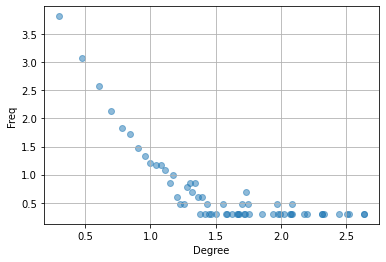

In [14]:
plot_loglog(graph.degree())

In [15]:
# we return only the first 5 nodes
graph.personalized_pagerank(reset_vertices = id_)[:5]

NameError: name 'id_' is not defined

In [ ]:
def print_top_k(graph, topk, opt, vid=None):
    """
    we print the top-k nodes with highest degree, pagerank and personalized-pagerank.
    
    Based on the selected option, a different top-k is generated
    """
    
    if opt == "degree":        
        # degree and node-idx
        deg = enumerate(graph.degree())
        
        # sorting the list "deg" by degree, extracting the top-k
        out = sorted(deg, key=lambda x: x[1], reverse=True)[:topk]
    
    if opt == "pagerank":
        
        pr = enumerate(graph.pagerank())

        # sorting the list "pr" by pagerank, extracting the top-k

        out = sorted(pr, key=lambda x: x[1], reverse=True)[:topk]
        
    if opt == "personalized-pr":
        
        # here we need also the argument vid, which corresponds to a node-id
        pr = enumerate(graph.personalized_pagerank(reset_vertices=vid))

        out = sorted(pr, key=lambda x: x[1], reverse=True)[:topk]
        
    return out

In [ ]:
print_top_k(graph, 10, "degree")

In [ ]:
print_top_k(graph, 10, "pagerank")

In [ ]:
#the first node is the vid, so should not be considered
print_top_k(graph, 10, "personalized-pr", 10)

In [16]:
def compute_ADA(u,v, graph):
    """
    compute adamic-adar from scratch
    """
    
    # set of neighbors of u
    outlinks_from_u = set(graph.neighbors(u))

    # set of neighbors of v
    inlinks_to_v = set(graph.neighbors(v))
    
    # set Z of neighbors of both
    bridges = outlinks_from_u.intersection(inlinks_to_v)

    # degree of nodes in set Z
    deg_ = [graph.degree(n) for n in bridges]
    
    # computing the reciprocal in log-scale
    out = [1./np.log2(dd+1) for dd in deg_]

    return sum(out)

In [17]:
compute_ADA(0,10, graph)

0

In [18]:
graph.vs[0]

igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 0, {'name': '-4580568379915793315'})

In [19]:
def find_nodes_at_distance_2(graph):
    """
    starting from a graph this function returns all the nodes at distance 2
    """
    

    all_potential_recommendations = set()
    
    for n1 in graph.vs:
        
        # all the nodes at distance 1
        nodes_at_most_distant_1 = set(graph.neighborhood(vertices=n1, order=1))

        # all the nodes at distance 1 and distance 2
        nodes_at_most_distant_2 = set(graph.neighborhood(vertices=n1, order=2))

        
        # only the nodes at distance 2
        only_nodes_at_distance_2 = nodes_at_most_distant_2 - nodes_at_most_distant_1
        
        
        # check if empty set
        if len(only_nodes_at_distance_2) > 0:
            

            for n2 in only_nodes_at_distance_2:
                
                # since n1 is an igraph vertex object, we need to extract the id
                n1_index = n1.index
                
                all_potential_recommendations.add((n1_index, n2))
            
    return all_potential_recommendations

In [20]:
all_potential_recommendations = find_nodes_at_distance_2(graph)

In [26]:
for i in all_potential_recommendations:
    print(graph.vs[i[0]])
    print(graph.vs[i[1]])

igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 3081, {'name': '1956047182465786871'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 4991, {'name': '-7140273200010946479'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 6885, {'name': '-8499353657827815711'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 6256, {'name': '-7113484220942958266'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 7563, {'name': '7629169584934757796'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 5188, {'name': '-1714450502647733312'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 8285, {'name': '966527628818514298'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 2140, {'name': '7127635916728773286'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 7461, {'name': '6836590528885296009'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 4911, {'name': '-5175479292013506426'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 2

igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 3902, {'name': '7248674914729170906'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 1526, {'name': '-3859658806018096556'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 230, {'name': '-7920430411807055023'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 2632, {'name': '7111195830321262309'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 2379, {'name': '-3641479934900695652'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 324, {'name': '6766138746602588684'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 7014, {'name': '-3388760853016597888'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 7933, {'name': '8126828648389426868'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 6890, {'name': '5581990439104311613'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 6177, {'name': '1906181433414760864'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 455

igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 1330, {'name': '1691056685118989412'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 1318, {'name': '-6682449087969431415'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 987, {'name': '-110584632996342866'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 2342, {'name': '-6372194349734273252'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 1310, {'name': '-3054044387654322074'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 6449, {'name': '5316397563043366468'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 132, {'name': '-1361519149202303392'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 6920, {'name': '-3709792962788191645'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 1969, {'name': '3721052798046500021'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 7603, {'name': '7687259267996245990'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 54

igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 4055, {'name': '8329833593851200210'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 9, {'name': '5225289324912870323'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 6864, {'name': '-7509889799675672014'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 6607, {'name': '2222337889569051786'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 1066, {'name': '-7179706082467218919'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 2303, {'name': '7457643674877043471'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 3774, {'name': '5395713611609263767'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 3931, {'name': '-1960585906532463716'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 942, {'name': '7716263616993982825'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 547, {'name': '1730806999372694928'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 4517, {

igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 3101, {'name': '6239327731826211208'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 1071, {'name': '-8639795990138709148'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 2224, {'name': '5724414080713310593'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 4839, {'name': '1122887760139745730'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 3832, {'name': '8913636104507025926'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 947, {'name': '5486975036790597915'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 468, {'name': '-1483844468092368887'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 231, {'name': '8124187712762692249'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 4462, {'name': '4747930545562087445'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 6458, {'name': '1872195643012328065'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 5496, 

igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 4762, {'name': '5596878077996861431'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 2060, {'name': '228749443459052837'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 386, {'name': '-6411793180879988672'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 5399, {'name': '4815178446665818835'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 5264, {'name': '-3397525884558946551'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 845, {'name': '-7916192833397627835'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 3501, {'name': '594570301476086501'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 5451, {'name': '-104593101410875522'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 5454, {'name': '-3215020071307086929'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 7481, {'name': '781889889817977942'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 8150, 

igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 3304, {'name': '-3726980678385714682'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 1295, {'name': '6405871873272114084'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 4797, {'name': '2905832281999049986'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 6038, {'name': '-4053732131795351304'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 3458, {'name': '-7329896398527115842'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 7397, {'name': '7036754148678548902'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 5827, {'name': '8513507274562528333'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 7307, {'name': '-4437093810143778892'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 4643, {'name': '3352003127527823359'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 5571, {'name': '-7306141787849494135'})
igraph.Vertex(<igraph.Graph object at 0x7fd7b4ff2400>, 

KeyboardInterrupt: 

In [22]:
print(len(list(graph.es)))

9028


In [27]:
# fraction of edges to select as test-set
p = 0.2

# graphsize 'edges'
N = len(graph.es)

# idxs of all the edges
all_idxs = range(N)

# sample idxs of edges through the function "choice"
test_idxs = np.random.choice(a=all_idxs, size=int(p*N), replace=False)

In [29]:
ground_truth = set()
trainset = set()
for idx, one_edge in enumerate(graph.es):
    
    # take n1 and n2 idx from one_edge, that is an igraph edge *object*
    n1 = one_edge.source
    n2 = one_edge.target

    if idx in test_idxs:
        
        ground_truth.add((n1, n2, 1))
    else:
        
        trainset.add((n1, n2, 1))

In [31]:
for rec in all_potential_recommendations:
    
    # add to ground truth also the potential nodes
    n1 = rec[0]
    n2 = rec[1]
    
    ground_truth.add((n1,n2,0))

In [36]:
## ALS
# first we get the adjacency matrix data
M = graph.get_adjacency().data
M = csr_matrix(M)

In [37]:
# here we run the model ALS
model = implicit.als.AlternatingLeastSquares(factors=10, calculate_training_loss=True,  iterations=5)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(M)

In [38]:
def predict_ALS(testset, model):
    """
    predict for a list of observations the score for adding/removing a link
    """

    # initialize the empty list
    all_predictions = []

    # scroll the obs
    for n1,n2, w in testset:
        
        # take here the low-dimensional vectors returned by the matrix factorization
        
        array_n1 = model.user_factors[n1,:]
        array_n2 = model.item_factors[n2,:]

        # multiplying these vectors we generate an approximation for the edge score
        one_p = np.dot(array_n1, array_n2)

        all_predictions.append(one_p)
        
    return all_predictions

In [39]:
# generate the predictions
df_test = pd.DataFrame(list(ground_truth), columns=["n1","n2", "edge"])
all_predictions = predict_ALS(df_test.values, model)

# add predictions to df
df_test["rating"] = all_predictions

# convert predictions to binary values: 0 don't add the edge, 1 add it.
df_test["rating"] = df_test["rating"].apply(lambda x: round(x))

In [41]:
# number of observations matched by the prediction
right_predictions = len(df_test[df_test.edge == df_test.rating])

# accuracy
right_predictions/len(df_test)

0.9985583439759933